In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import polars as pl


In [2]:
# the last pre-COVID full stop-level count was in 2016
ridership_stop_2016 = pl.read_excel(
    r"Q:\Data\Observed\Transit\Muni\Ridership\RailRidership\LRV_Weekday_Spring2016_byHour with stop_ID.xlsx",
    sheet_name="MUNI_EXPANDED_DB",
).with_columns(
    # pl.col("ROUTE").str.strip_chars_end(),  # strip trailing space
    pl.col("HOUR").cast(pl.Time),
    route_alpha=pl.col("ROUTE").str.split("-").list.first(),
)
# we have line-based ridership estimates from Fall 2019
ridership_line_2019 = pl.read_csv(
    r"Q:\Data\Observed\Transit\Muni\Ridership\RailRidership\Fall 2019 Rail Ridership By Route.csv"
).with_columns(route_alpha=pl.col("ROUTE_NAME").str.split("-").list.first())

In [3]:
ridership_line_2016 = (
    ridership_stop_2016.group_by("route_alpha")
    .agg(pl.sum("EXPANDED_BOARD (TOTAL)", "EXPANDED_ALIGHT (TOTAL)"))
    .with_columns(
        ridership_line_2016=pl.mean_horizontal(
            "EXPANDED_BOARD (TOTAL)", "EXPANDED_ALIGHT (TOTAL)"
        ),
    )
)
# verified that total boardings = total alightings for each line
display(ridership_line_2016)
ridership_line_2016 = ridership_line_2016.select("route_alpha", "ridership_line_2016")

route_alpha,EXPANDED_BOARD (TOTAL),EXPANDED_ALIGHT (TOTAL),ridership_line_2016
str,f64,f64,f64
"""N""",49149.057435,49149.057435,49149.057435
"""M""",31007.219796,31007.219796,31007.219796
"""KT""",42528.948714,42528.948714,42528.948714
"""J""",15594.266117,15594.266117,15594.266117
"""L""",33254.161111,33254.161111,33254.161111


In [4]:
ridership_line_2016.join(
    ridership_line_2019.filter(pl.col("MUNI_FORWARD_CATEGORY") == "Muni Metro").select(
        "route_alpha",
        ridership_line_2019fall=pl.col("Sept/Oct 2019").str.replace(",", "").cast(int),
    ),
    on="route_alpha",
).with_columns(
    (pl.col("ridership_line_2019fall") / pl.col("ridership_line_2016")).alias(
        "2019/2016"
    ),
)
# an unusual sharp drop for KT, confirmed by https://www.sfmta.com/reports/average-daily-muni-boardings-route-and-month-pre-pandemic-present
# looking at news articles, it may be due to construction/closures around Chase Center
# So let's just scale to ridership from Feb 2020 for J/L/M/N, and from Feb 2019 for KT


route_alpha,ridership_line_2016,ridership_line_2019fall,2019/2016
str,f64,i64,f64
"""J""",15594.266117,15700,1.00678
"""KT""",42528.948714,32900,0.773591
"""L""",33254.161111,33700,1.013407
"""M""",31007.219796,32700,1.054593
"""N""",49149.057435,50600,1.029521


In [5]:
# from https://www.sfmta.com/reports/average-daily-muni-boardings-route-and-month-pre-pandemic-present
# ridership for J, L, M, N from Feb 2020
# ridership for KT from Feb 2019, because there's a sharp drop in ridership in
# summer 2019 that lasts until the start of COVID, probably due to construction and
# closures around Chase Center. It would be impossible to reconstruct stop-based
# ridership for Feb 2020, since we don't know if the drop is only around Mission Bay
# or a uniform drop along the full KT line.
ridership_line_precovidfeb = pl.DataFrame(
    {
        "route_alpha": ["J", "KT", "L", "M", "N"],
        # KT: 2020 Feb: weekday 32400, sat 16600, sun 17000
        "precovid_weekday": [15400, 37400, 33200, 32200, 49800],
        "precovid_sat": [9300, 22600, 18200, 15900, 25700],
        "precovid_sun": [7600, 14700, 14500, 13300, 20000],
    }
).with_columns(precovid_weekend=pl.mean_horizontal("precovid_sat", "precovid_sun"))


In [6]:
ridership_line = ridership_line_2016.join(
    ridership_line_precovidfeb.select(
        "route_alpha", "precovid_weekday", "precovid_weekend"
    ),
    on="route_alpha",
).with_columns(
    (pl.col("precovid_weekday") / pl.col("ridership_line_2016")).alias(
        "2016_to_precovid_weekday"
    ),
    (pl.col("precovid_weekend") / pl.col("ridership_line_2016")).alias(
        "2016_to_precovid_weekend"
    ),
)

In [7]:
ridership_stop_precovidfeb_estimate = ridership_stop_2016.join(
    ridership_line, on="route_alpha"
).select(
    "route_alpha",
    "DIRECTION",
    "STOP NAME",
    "STOP ID",
    "HOUR",
    total_board_weekday=pl.col("EXPANDED_BOARD (TOTAL)")
    * pl.col("2016_to_precovid_weekday"),
    total_alight_weekday=pl.col("EXPANDED_ALIGHT (TOTAL)")
    * pl.col("2016_to_precovid_weekday"),
    total_board_weekend=pl.col("EXPANDED_BOARD (TOTAL)")
    * pl.col("2016_to_precovid_weekend"),
    total_alight_weekend=pl.col("EXPANDED_ALIGHT (TOTAL)")
    * pl.col("2016_to_precovid_weekend"),
)
ridership_stop_precovidfeb_estimate = pl.concat(
    [
        ridership_stop_precovidfeb_estimate.select(
            "route_alpha",
            "DIRECTION",
            "STOP NAME",
            "STOP ID",
            "HOUR",
            total_board=pl.col("total_board_weekday"),
            total_alight=pl.col("total_alight_weekday"),
            weekday=pl.lit(True),
        ),
        ridership_stop_precovidfeb_estimate.select(
            "route_alpha",
            "DIRECTION",
            "STOP NAME",
            "STOP ID",
            "HOUR",
            total_board=pl.col("total_board_weekend"),
            total_alight=pl.col("total_alight_weekend"),
            weekday=pl.lit(False),
        ),
    ]
)


In [8]:
# plot KT ridership along line for stop based data from 2016 & 2024 for sanity check

In [9]:
ridership_2024_xlsx_filepath = (
    r"C:\Users\cchow\Desktop\tmp\downtown_today\muni\COMP1_2024_01_20_Excel.xlsx"
)
ridership_2024_xlsx_sheet_name = "COMP1_2024_01_20"
ridership_stop_2024 = pl.read_excel(
    ridership_2024_xlsx_filepath, sheet_name=ridership_2024_xlsx_sheet_name
)


In [10]:
def muni_metro_2016_add_latlong(
    ridership_stop_2016: pl.DataFrame, ridership_stop_2024: pl.DataFrame
):
    return ridership_stop_2016.join(
        ridership_stop_2024.select(["BS_ID", "STOP_LAT", "STOP_LONG"]).unique(),
        left_on="STOP ID",
        right_on="BS_ID",
        how="left",
    )


ridership_stop_2016 = muni_metro_2016_add_latlong(
    ridership_stop_2016, ridership_stop_2024
)


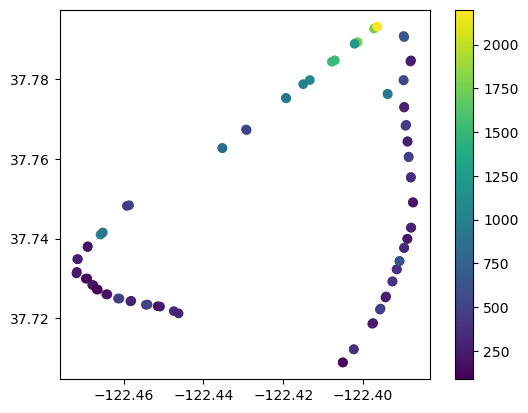

In [11]:
kt_weekday_2016 = (
    ridership_stop_2016.filter(pl.col("route_alpha") == "KT")
    .group_by(["STOP NAME", "STOP_LAT", "STOP_LONG"])
    .agg(pl.sum("EXPANDED_BOARD (TOTAL)", "EXPANDED_ALIGHT (TOTAL)"))
    .with_columns(
        avg_on_offs=pl.mean_horizontal(
            ("EXPANDED_BOARD (TOTAL)", "EXPANDED_ALIGHT (TOTAL)")
        )
    )
    .to_pandas()
)
gpd.GeoDataFrame(
    kt_weekday_2016,
    geometry=gpd.points_from_xy(
        kt_weekday_2016["STOP_LONG"], kt_weekday_2016["STOP_LAT"]
    ),
).plot(column="avg_on_offs", legend=True)
plt.show()


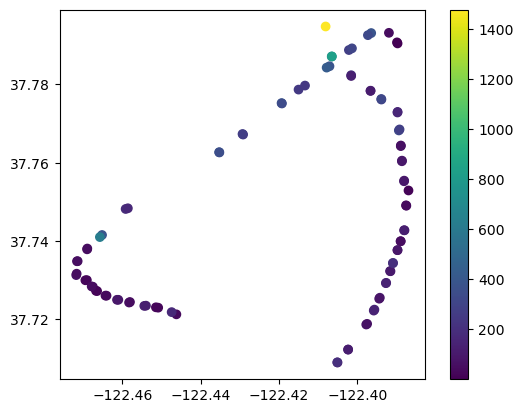

In [12]:
kt_weekday_2024 = (
    ridership_stop_2024.filter(
        (pl.col("SERVICE_DAY_OF_WEEK") == "WEEKDAY")
        & pl.col("ROUTE_ALPHA").is_in({"K", "T"})
    )
    .group_by(["Stop Name", "STOP_LAT", "STOP_LONG"])
    .agg(pl.sum("AVG_VEH_ONS", "AVG_VEH_OFFS"))
    .with_columns(avg_on_offs=pl.mean_horizontal(("AVG_VEH_ONS", "AVG_VEH_OFFS")))
).to_pandas()
gpd.GeoDataFrame(
    kt_weekday_2024,
    geometry=gpd.points_from_xy(
        kt_weekday_2024["STOP_LONG"], kt_weekday_2024["STOP_LAT"]
    ),
).plot(column="avg_on_offs", legend=True)
plt.show()
